# Analyzing Play Time Contribution by Different Player Types

## Introduction

PLAI, an AI research group within the Faculty of Computer Science at UBC, has set up a Minecraft server to develop an AI that surpasses current technological constraints. Through this server, the researchers have gathered data on participants' in-game actions and communication, with the goal of collecting over 10,000 hours of data to create a complex AI that replicates player-like behaviour within the virtual world, or similarly, an AGI (Artificial General Intelligence)-like agent. However, to gather more significant data, PLAI researchers aim to identify which players, or player types, contribute the most hours of gameplay. Therefore, this analysis will address the following question: Can we determine which players are most likely to contribute the most hours of gameplay based on their age and experience with the game?

To answer the question, this project uses two datasets containing player information and session details: ```players.csv``` and ```sessions.csv```.

*[ ] indicates variable data type

---

```players.csv```: A dataset containing identifying information provided during recruitment for all participants, including their total playtime. It contains 196 **observations** and 9 **variables**.

- ```experience```: Participant's self-reported Minecraft experience level [Character/Categorical] - (Amateur, Beginner, Regular, Pro, Veteran).
- ```subscribe```: Whether the participant is subscribed to PLAI emails [Character].
- ```hashedEmail```: The participant's provided email address, encrypted for privacy [Character]. 
- ```played_hours```: Total number of hours the participant has played on the server [Double].
- ```name```: The participant's provided name [Character].
- ```gender```: The participant's identified gender [Character].
- ```age```: The participant's age [Double].
- ```IndividualID```: The participant's ID; another means of identification [Logical].*
- ```organizationName```: The participant's affiliated organization [Logical].*

*Note: **IndividualID** and **organizationName** are labelled as NA and are not provided in the dataset.

---


```sessions.csv```: A dataset containing each play session per individual, including their start and end times. It contains 1535 **observations** and 5 **variables**. 

- ```hashedEmail```: The participant's provided email address, encrypted for privacy [Character].
- ```start_time```: Session start date (dd/mm/yyyy) and time (24hr) [Character].
- ```end_time```: Session end date (dd/mm/yyyy) and time (24hr) [Character].
- ```original_start_time```: Session start time in UNIX timestamp - seconds since Jan 1st, 1970 (UTC) [Double].
- ```original_end_time```: Session end time in UNIX timestamp - seconds since Jan 1st, 1970 (UTC) [Double].

---

## Methods & Results

We will use **KNN-Classification** with `age` and `played_hours` as predictor variables, identifying the types of players that have the highest playtime. To address the question, we will use the categorical variable, `experience`, to classify players as **Amateurs**, **Beginners**, **Regulars**, **Pros**, or **Veterans**.

In [1]:
# Loading Packages into R

#Contains most functions needed for analysis
library(tidyverse) 

#To obtain colors for visualization: Colorblind friendly Palettes
library(RColorBrewer) 


#Contains the functions to create a model
library(tidymodels)

#Controls how R objects are displayed. Enhances the details of outputs by indirectly formatting how they appear (ex. options). 
library(repr)

#To obtain a maximum of 5 rows per data frame
options(repr.matrix.max.rows = 5) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#Loading both datasets (players and session data) into the datafile. 
players <- read_csv ("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

sessions <- read_csv ("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Setting the Seed
set.seed (100)


#Wrangling the data - Begin with removing unknown columns in players
players_no_unknown <- players |>
select (-individualId, -organizationName)

#Merging sessions and players_no_unknown together based on matches of the hashedEmail observation
playdate <- merge (x = players_no_unknown, y = sessions, by = "hashedEmail", all = TRUE)

#Select the columns of interest (experience, played_hours, age, start_time, end_time)
playdate_select <- playdate |>
select (experience, played_hours, age, start_time, end_time)

#Remove all instances where the start time or end time is NA. These individuals did not input any time and logged irrelevant playtime data. 
playdate_no_NA <- playdate_select |>
filter (start_time != "NA", end_time != "NA")

#Convert start_time and end_time to a proper date-time format that R recognizes as dates and times. 
 playdate_time <- playdate_no_NA |>
mutate (start_time = as.POSIXct (start_time, format = "%d/%m/%Y %H:%M")) |>
mutate (end_time = as.POSIXct (end_time, format = "%d/%m/%Y %H:%M"))

#Obtain the difference varaible in start and end time with the difftime() function
playdate_diff <- playdate_time |>
mutate (difference = difftime (end_time, start_time, units = "mins"))

#Finally, display the first and last 5 rows
head(playdate_diff)
tail(playdate_diff)


,experience,played_hours,age,start_time,end_time,difference
,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<drtn>
1,Regular,1.5,20,2024-05-23 00:22:00,2024-05-23 01:07:00,45 mins
2,Regular,1.5,20,2024-05-22 23:12:00,2024-05-23 00:13:00,61 mins
3,Pro,0.4,21,2024-06-28 04:28:00,2024-06-28 04:58:00,30 mins
⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,Regular,5.6,17,2024-08-30 03:40:00,2024-08-30 04:04:00,24 mins
6,Regular,5.6,17,2024-08-27 19:18:00,2024-08-27 19:52:00,34 mins


,experience,played_hours,age,start_time,end_time,difference
,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<drtn>
1528,Amateur,56.1,23,2024-07-25 07:38:00,2024-07-25 07:42:00,4 mins
1529,Amateur,56.1,23,2024-07-03 06:22:00,2024-07-03 06:27:00,5 mins
1530,Amateur,56.1,23,2024-07-25 07:32:00,2024-07-25 07:36:00,4 mins
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1532,Amateur,0.1,17,2024-09-14 15:33:00,2024-09-14 15:42:00,9 mins
1533,Beginner,1.1,20,2024-04-26 09:11:00,2024-04-26 10:23:00,72 mins


---> This is where we need to rework stuff

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


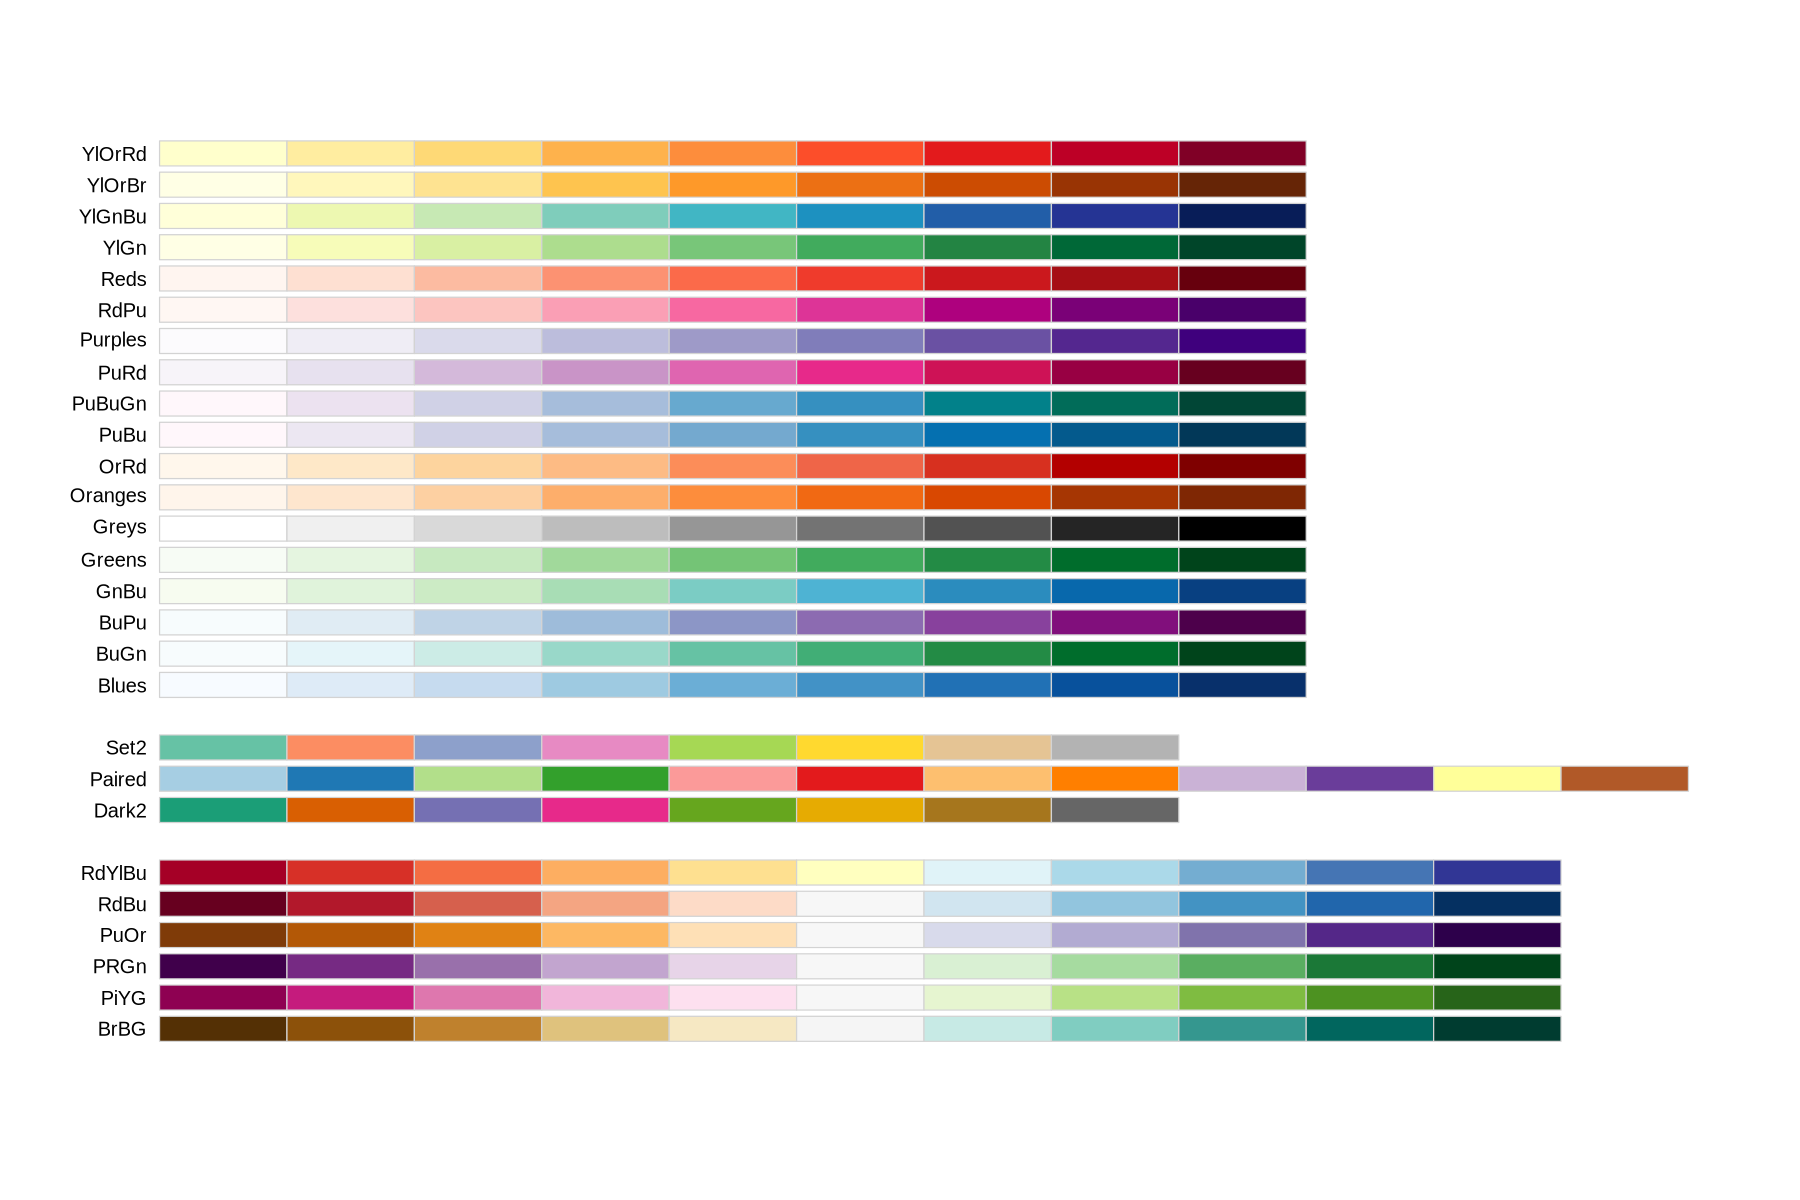

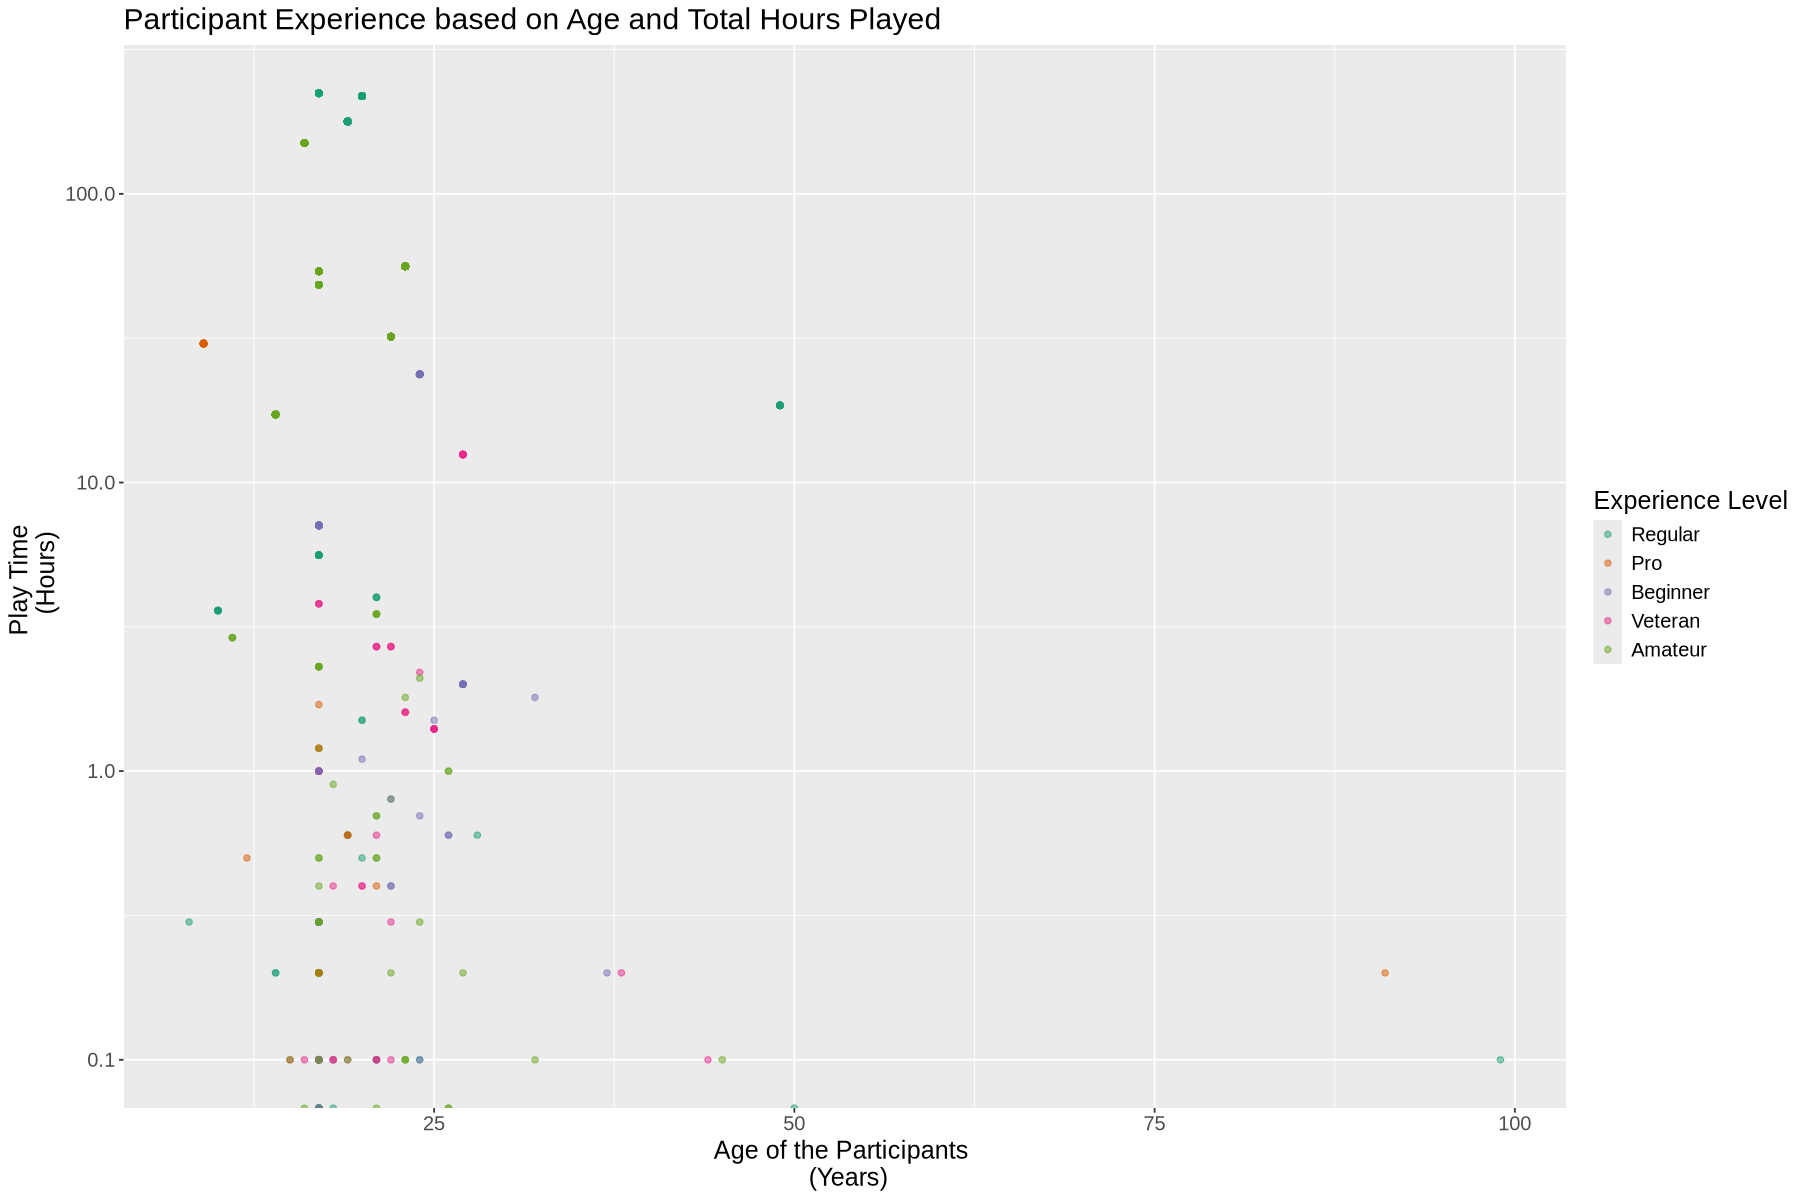

In [4]:
#Copy and reword this code if we don't need start_time, end_time, and difference:
options (repr.plot.width = 15, repr.plot.height = 10)


#Final Cleaning of the data and turning the experience variable to a categorical variable
playdate_final <- playdate_diff |>
select (experience:age) |>
mutate (experience = as_factor(experience))

display.brewer.all (colorblindFriendly = TRUE)

#Creating a visualization to see what we're working with; x = age as it is independent, y = played_hours as it might change based on age
playdate_vision <- playdate_final |>
ggplot (aes(x = age, y = played_hours, color = experience)) +
geom_point(alpha = 0.5) +
scale_color_brewer (palette = "Dark2") +
labs (x = "Age of the Participants \n (Years)", y = "Play Time \n (Hours)", title = "Participant Experience based on Age and Total Hours Played"
      , color = "Experience Level") +
theme (text = element_text (size = 15)) +
scale_y_log10 ()

playdate_vision



In [9]:
#Numbering experience levels off 
play_data_edit <- playdate_final |>
mutate(experience =case_when(experience=="Veteran" ~ 5, experience=="Pro" ~ 4, experience=="Regular" ~ 3,experience=="Amateur" ~ 2, experience == "Beginner" ~ 1))
head(play_data_edit)

,experience,played_hours,age
,<dbl>,<dbl>,<dbl>
1,3,1.5,20
2,3,1.5,20
3,4,0.4,21
⋮,⋮,⋮,⋮
5,3,5.6,17
6,3,5.6,17


## Discussion

Further research could be done on how to identify or classify a player as one of the five types. For example, what makes a specific player a pro level? An amateur level?

## References

For the merge function: https://stackoverflow.com/questions/1299871/how-to-join-merge-data-frames-inner-outer-left-right

For POSIXct: https://stackoverflow.com/questions/43460329/converting-datetime-from-character-to-posixct-object

For difftime() function: https://www.statology.org/r-difftime-function/#:~:text=You%20can%20use%20the%20difftime,dates%20or%20datetimes%20in%20R.&text=where%3A,%E2%80%9D%2C%20and%20%E2%80%9Cweeks%E2%80%9D)